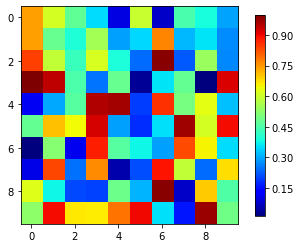

In [7]:
import matplotlib.ticker as ticker
import numpy as np
import cv2
import torch
import torch.nn.functional as F

import mmcv
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig = plt.figure()
ax = fig.gca()
im = ax.imshow(np.random.random([10, 10]),cmap=plt.get_cmap('jet'))
cb1 = plt.colorbar(im, fraction=0.03, pad=0.05)
tick_locator = ticker.MaxNLocator(nbins=8)  # colorbar上的刻度值个数
cb1.locator = tick_locator
cb1.update_ticks()
plt.show()

def show_cmap(cmap, norm=None, extend=None):
    '''展示一个colormap.'''
    if norm is None:
        norm = mcolors.Normalize(vmin=0, vmax=cmap.N)
    im = cm.ScalarMappable(norm=norm, cmap=cmap)

    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    fig.colorbar(im, cax=ax, orientation='horizontal', extend=extend)
    plt.show()


